In [20]:
#Imports
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [22]:
#Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [23]:
#Create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [24]:
#Reflect an existing database into a new model
Base = automap_base()
#Reflect the tables
Base.prepare(autoload_with = engine)

In [25]:
#Classes that automap found
Base.classes.keys()

['measurement', 'station']

In [26]:
#Measurement columns & types
meas_cols = inspect(engine).get_columns('measurement')
for col in meas_cols:
    print(col['name'], col['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [27]:
#Station columns & types
stat_cols = inspect(engine).get_columns('station')
for col in stat_cols:
    print(col['name'], col['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [28]:
#References to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [29]:
#Create session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [33]:
#Find the most recent date in the data set.
session.query(measurement.date).order_by(measurement.date.desc()).first()

('2017-08-23',)

In [12]:
#Find the date a year from the most recent.
last_year = str(dt.date(2017, 8, 23)- dt.timedelta(days=365))
last_year

'2016-08-23'

In [18]:
#Retrieve the last 12 months of precipitation data and plot the results. 
#Starting from the most recent data point in the database. 
#Retrieve the date and precipitation scores & save as a Pandas DataFrame & set column names
precip_df = pd.DataFrame(session.query(measurement.date, measurement.prcp).filter(measurement.date <= '2017-08-23').\
        filter(measurement.date > '2016-08-23').order_by(measurement.date).all(), columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precip_df_sorted = precip_df.sort_values(by='Date', ascending=True)
precip_df_sorted = precip_df_sorted[['Date', 'Precipitation']]
precip_df_sorted.set_index('Date', inplace=True)
precip_df_sorted.head()

,Precipitation
Date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


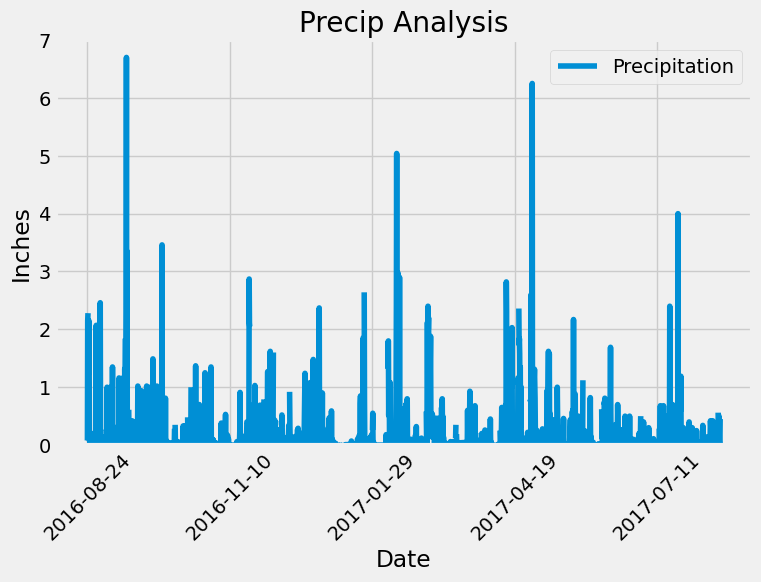

<Figure size 640x480 with 0 Axes>

In [19]:
#Plot the data
precip_plot = precip_df_sorted.plot(ylim=(0,7), figsize= (8,5), title='Precip Analysis', rot=45)
precip_plot.set_xlabel('Date')
precip_plot.set_ylabel('Inches')

plt.show()
plt.tight_layout()

In [53]:
#The summary statistics for the precipitation data
precip_df_sorted.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [56]:
#Total number of stations in the dataset
session.query(station.station).count()

9

In [57]:
#Find the most active stations (i.e. which stations have the most rows?)
#List the stations and their counts in descending order.
station_q = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
station_q

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [60]:
#Calculate the lowest, highest, and average temperature of the most acitve station ID.
t_obs = session.query(measurement.tobs).filter(measurement.station == station_q[0][0])
lowest = t_obs.order_by(measurement.tobs).first()
highest = t_obs.order_by(measurement.tobs.desc()).first()
sum = session.query(func.sum(measurement.tobs)).filter(measurement.station == station_q[0][0]).all()
average = sum[0][0]/station_q[0][1]
print('Lowest:', lowest, 'Highest:', highest, 'Average:', average)

Lowest: (54.0,) Highest: (85.0,) Average: 71.66378066378067


In [67]:
#Query the last 12 months of temperature observation data for the most active station and plot the results as a histogram
tobs_data = session.query(measurement.tobs, measurement.prcp).filter(measurement.station == station_q[0][0]).filter(measurement.date > last_year, measurement.date).all()
#Save the query results into a Data Frame for histogram plotting
stat_df = pd.DataFrame(tobs_data, columns = ['Temperature', 'Date'])
stat_df

,Temperature,Date
0,77.0,2.15
1,80.0,0.06
2,80.0,0.01
3,75.0,0.12
4,73.0,0.60
...,...,...
346,77.0,0.00
347,77.0,0.32
348,76.0,0.12
349,76.0,0.01


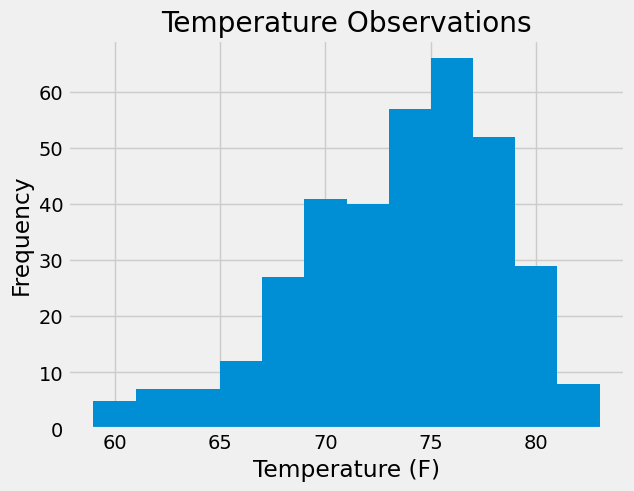

In [68]:
#Plot histogram
plt.hist(stat_df['Temperature'], bins = 12)
plt.title("Temperature Observations")
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")

plt.show()

# Close Session

In [69]:
#Close Session
session.close()